In [1]:
using QuantumCumulants
using OrdinaryDiffEq, ModelingToolkit
using DifferentialEquations
using PyPlot
import LinearAlgebra as la

multiplier = 1e9
M_1 = 10900
M_3 = 1750
# M_3 = 0.175
y1 = 2*pi*2.94e-3*multiplier
y3 = 1.76e-2*multiplier

@cnumbers ω1 ω2 ω3 g1 g2 γ1 γ2 γ3 Ω1 Ω2 Ω3  # 2-magnon, 2-photon
h1 = FockSpace(:cavity);h2 = FockSpace(:cavity);h3 = FockSpace(:cavity)
h=h1⊗h2⊗h3
# Define the fundamental operators
@qnumbers b1::Destroy(h,1) b2::Destroy(h,2) b3::Destroy(h,3)
#            magnon PY          resonator        magnon YIG

Ham = ω1*(b1'*b1) + ω2*(b2'*b2) + ω3*(b3'*b3) + g1*((b1'*b2)+(b2'*b1)) + g2*((b3'*b2)+(b2'*b3)) + Ω1*( b1'+b1) + Ω2*(b2'+b2) + Ω3*(b3'+b3)
# Collapse operators
J = [b1,b2,b3]; rates = [2γ1,2γ2,2γ3]
# Derive a set of equations
ops = [b1,b2,b3]; eqs = meanfield(ops,Ham,J;rates=rates,order=1)

# Complete equations
eqs_completed = complete(eqs);
@named sys = ODESystem(eqs_completed);
A = calculate_jacobian(sys); B=[eqs_completed[1].rhs.dict[Ω1] * Ω1; eqs_completed[2].rhs.dict[Ω2] * Ω2; eqs_completed[3].rhs.dict[Ω3] * Ω3];
Ainv=inv(A); X=Ainv*B; b1=X[1]; b2=X[2]; b3=X[3];

In [5]:
display(eqs)
display(eqs_completed)

∂ₜ(⟨b1⟩) = (0 - 1im)*Ω1 + (0 - 1im)*g1*⟨b2⟩ + (0 - 1im)*ω1*⟨b1⟩ - γ1*⟨b1⟩
∂ₜ(⟨b2⟩) = (0 - 1im)*Ω2 + (0 - 1im)*g1*⟨b1⟩ + (0 - 1im)*ω2*⟨b2⟩ + (0 - 1im)*g2*⟨b3⟩ - γ2*⟨b2⟩
∂ₜ(⟨b3⟩) = (0 - 1im)*Ω3 + (0 - 1im)*g2*⟨b2⟩ + (0 - 1im)*ω3*⟨b3⟩ - γ3*⟨b3⟩


∂ₜ(⟨b1⟩) = (0 - 1im)*Ω1 + (0 - 1im)*g1*⟨b2⟩ + (0 - 1im)*ω1*⟨b1⟩ - γ1*⟨b1⟩
∂ₜ(⟨b2⟩) = (0 - 1im)*Ω2 + (0 - 1im)*g1*⟨b1⟩ + (0 - 1im)*ω2*⟨b2⟩ + (0 - 1im)*g2*⟨b3⟩ - γ2*⟨b2⟩
∂ₜ(⟨b3⟩) = (0 - 1im)*Ω3 + (0 - 1im)*g2*⟨b2⟩ + (0 - 1im)*ω3*⟨b3⟩ - γ3*⟨b3⟩


In [55]:
H=250

function crossover_strength(;γ1n=0,γ2n=0,γ3n=0,ω2n=3.16*2e9*pi,g1n=.15*2e9*pi,g2n=.17*2e9*pi,H=H)
    ω3n = H -> y3 * (H*(H+M_3))^.5
    ω1n = H -> y1 * (H*(H+M_1))^.5
    An=substitute( A, Dict(ω1=>ω1n(H),ω2=>ω2n,ω3=>ω3n(H),g1=>g1n,g2=>g2n,γ1=>γ1n,γ2=>γ2n,γ3=>γ3n))
    Ann = 1im * zeros(3,3)
    for i=1:3
        for j=1:3
            Ann[i,j] = real(An[i,j]).val + 1im * imag(An[i,j]).val
        end
    end
    if any(isinf, Ann) || any(isnan, Ann)
        println("Inf or NaN detected!")
        println("Parameters: H=$H, g1n=$g1n, g2n=$g2n, γ1n=$γ1n, γ2n=$γ2n, γ3n=$γ3n")
    end
    data0=Ann * 1im
    data1 = la.eigen(data0)

    datar=la.real(data1.values)
    sort!(datar,rev=true)
    # datar = filter(x -> x >= 2.8e10 && x <= 3.8e10, datar) # filter out solutions outside region of interest
    if length(datar) == 1 || length(datar) == 0
        println("No crossover found at $H Oe...")
        return 0
    end
    abs_diff = abs(datar[1] - datar[2])
    return abs_diff*2*pi/1e10
end

crossover_strength (generic function with 8 methods)

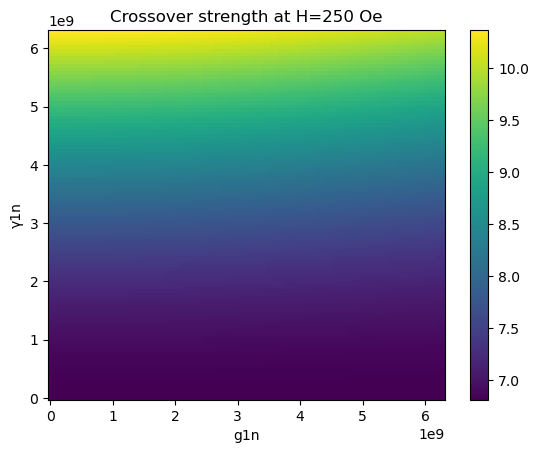

In [56]:
g1n = collect(range(0, stop=1, length=100))*2e9*pi
γ1n = collect(range(0, stop=1, length=100))*2e9*pi

cross_array = zeros(length(g1n), length(γ1n))
for (idx,g1n_val) in enumerate(g1n)
    for (jdx,γ1n_val) in enumerate(γ1n)
        cross_array[idx,jdx] = crossover_strength(γ1n=γ1n_val, g1n=g1n_val)
    end
end

fig, ax = plt.subplots()
c = ax.pcolor(g1n, γ1n, cross_array)#, norm=matplotlib.colors.LogNorm())
ax.set_xlabel("g1n")
ax.set_ylabel("γ1n")
ax.set_title("Crossover strength at H=$H Oe")
fig.colorbar(c, ax=ax)
plt.show()

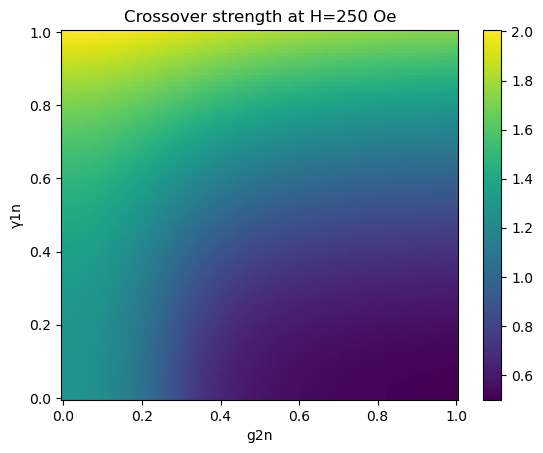

In [53]:
g2n = collect(range(0, stop=1, length=100))
γ1n = collect(range(0, stop=1, length=100))

cross_array = zeros(length(g2n), length(γ1n))
for (idx,g2n_val) in enumerate(g2n)
    for (jdx,γ1n_val) in enumerate(γ1n)
        cross_array[idx,jdx] = crossover_strength(γ1n=γ1n_val, g2n=g2n_val)
    end
end

fig, ax = plt.subplots()
c = ax.pcolor(g2n, γ1n, cross_array)
ax.set_xlabel("g2n")
ax.set_ylabel("γ1n")
ax.set_title("Crossover strength at H=$H Oe")
fig.colorbar(c, ax=ax)
plt.show()